#Step 1: Setup and Data Loading

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.utils import make_grid
import pandas as pd
import gzip

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the Fashion MNIST data (using the code you provided)
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels


Using device: cpu


In [ ]:
# Load the data
X_train, y_train = load_mnist('fashion_mnist_data', kind='train')
X_test, y_test = load_mnist('fashion_mnist_data', kind='t10k')

In [ ]:
# Normalize pixel values to [-1, 1] range (better for GAN training)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_test = (X_test.astype(np.float32) - 127.5) / 127.5

In [ ]:
# Reshape to (num_samples, channels, height, width)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

In [ ]:
# Convert to PyTorch tensors
train_data = torch.tensor(X_train, dtype=torch.float32)
train_labels = torch.tensor(y_train, dtype=torch.long)
test_data = torch.tensor(X_test, dtype=torch.float32)
test_labels = torch.tensor(y_test, dtype=torch.long)

In [ ]:
# Create datasets and dataloaders
batch_size = 128

train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Class labels mapping
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


In [ ]:
# Function to show some real images
def show_real_images(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Denormalize images
    images = images / 2 + 0.5
    img_grid = make_grid(images[:25], nrow=5, normalize=True)

    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Real Fashion MNIST Images")
    plt.show()

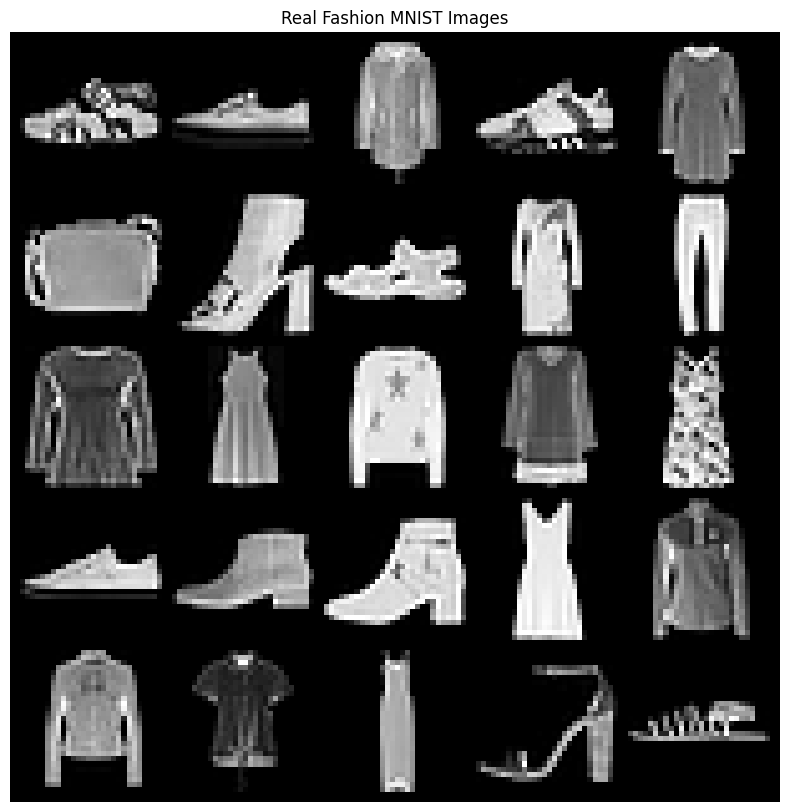

In [ ]:
show_real_images(train_loader)

#Step 2: Define the Generator and Discriminator Networks

In [ ]:
# Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # Input is latent_dim (noise), output is 128*7*7
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),

            # Reshape to 128x7x7
            nn.Unflatten(1, (128, 7, 7)),

            # Upsample to 28x28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1] range
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
# Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input is 1x28x28
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Flatten and output a single value (real/fake)
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
# Initialize models
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [ ]:
# Print model architectures
print("Generator Architecture:")
print(generator)
print("\nDiscriminator Architecture:")
discriminator

Generator Architecture:
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(128, 7, 7))
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Tanh()
  )
)

Discriminator Architecture:


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6272, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

#Step 3: Define Loss Functions and Optimizers

In [ ]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

#Step 4: Training the GAN

In [ ]:
# Training parameters
num_epochs = 50
sample_interval = 400  # Save generated images every N batches

# For plotting the loss
G_losses = []
D_losses = []

# Fixed noise for visualization
fixed_noise = torch.randn(25, latent_dim, device=device)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        # Move real images to device
        real_images = real_images.to(device)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

In [ ]:

        # Zero gradients
        optimizer_D.zero_grad()

        # Forward pass real images through discriminator
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)

        # Generate fake images
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_images = generator(noise)

In [ ]:
import torch

# Forward pass real images through discriminator
outputs_real = discriminator(real_images)
loss_real = criterion(outputs_real, real_labels)

# Forward pass fake images through discriminator
outputs_fake = discriminator(fake_images.detach())  # Detach to avoid updating the generator
loss_fake = criterion(outputs_fake, fake_labels)

# Total discriminator loss
loss_D = loss_real + loss_fake

# Backward pass and optimize discriminator
optimizer_D.zero_grad()  # Zero gradients
loss_D.backward()
optimizer_D.step()

# Zero gradients for generator
optimizer_G.zero_grad()

# Generate fake images again (since we updated the discriminator)
noise = torch.randn(batch_size, latent_dim, device=device)
fake_images = generator(noise)


In [ ]:
# Forward pass: Generate fake images
fake_images = generator(noise)

# Forward pass fake images through discriminator
outputs = discriminator(fake_images)

# Generator wants discriminator to think these are real
loss_G = criterion(outputs, real_labels)

# Backward pass and optimize
optimizer_G.zero_grad()  # Zero the gradients
loss_G.backward()
optimizer_G.step()

# Save losses for plotting
G_losses.append(loss_G.item())
D_losses.append(loss_D.item())  # Ensure loss_D is calculated before using


In [ ]:
# Print training progress
if i % 100 == 0:
    print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
          f"D_loss: {loss_D.item():.4f} G_loss: {loss_G.item():.4f}")

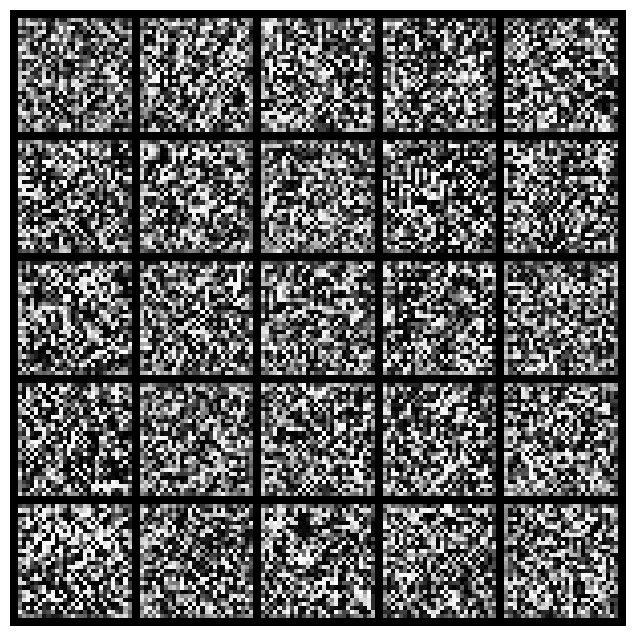

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Generate and save sample images at the end of each epoch
with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()

    # Denormalize
    fake = fake * 0.5 + 0.5

    # Create grid of images
    img_grid = make_grid(fake, nrow=5, normalize=True)

    # Plot the images
    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


#Step 5: Plot Training Losses

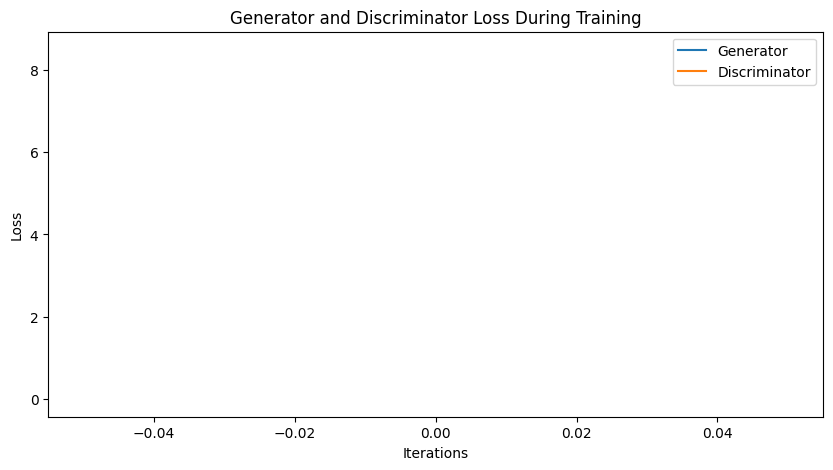

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#Step 6: Generate and Save New Fashion Images

In [ ]:
# Generate new fashion images
def generate_images(num_images, save_dir="generated_fashion"):
    os.makedirs(save_dir, exist_ok=True)

    # Generate noise
    noise = torch.randn(num_images, latent_dim, device=device)

    # Generate images
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    # Denormalize
    generated_images = generated_images / 2 + 0.5

In [ ]:
import os
import torch
import matplotlib.pyplot as plt

def generate_images(num_images, generator, save_dir="generated_images"):
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Generate images
    with torch.no_grad():
        noise = torch.randn(num_images, latent_dim, 1, 1, device=device)  # Make sure latent_dim and device are defined
        generated_images = generator(noise).cpu()

    # Save images
    for i in range(num_images):
        img = generated_images[i].squeeze().numpy()
        plt.imsave(os.path.join(save_dir, f"fashion_{i}.png"), img, cmap='gray')

    print(f"Generated {num_images} images and saved to {save_dir}")


In [ ]:
# Show some of the generated images
def show_generated_images(n=25):
    noise = torch.randn(n, latent_dim, device=device)

    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    # Denormalize
    generated_images = generated_images / 2 + 0.5

    # Create grid
    img_grid = make_grid(generated_images, nrow=5, normalize=True)


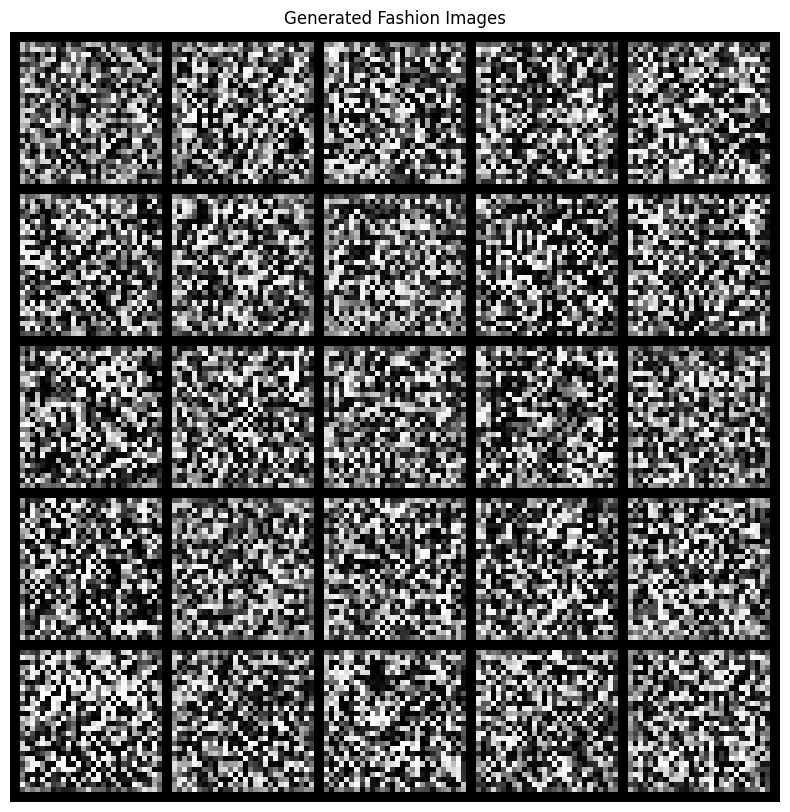

In [ ]:
import matplotlib.pyplot as plt

def show_generated_images(img_grid):
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Fashion Images")
    plt.show()

# Call the function with your generated image grid
show_generated_images(img_grid)


#Evaluating GAN Model Accuracy

In [ ]:
def visualize_generated_images(generator, num_images=25, latent_dim=100):
    """Visualize generated images from the generator"""
    # Generate random noise
    noise = torch.randn(num_images, latent_dim, device=device)

    # Generate images
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    # Denormalize images
    generated_images = generated_images / 2 + 0.5

    # Create grid
    img_grid = make_grid(generated_images, nrow=5, normalize=True)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Generated Fashion Images")
    plt.show()

# Call the function
visualize_generated_images(generator)

##1. Discriminator Accuracy (Quantitative Evaluation)


In [ ]:
def evaluate_discriminator(discriminator, generator, test_loader, num_test_samples=1000):
    """Evaluate discriminator's ability to distinguish real vs fake images"""
    discriminator.eval()
    generator.eval()

    real_correct = 0
    fake_correct = 0
    total = 0

    # Test on real images
    for i, (real_images, _) in enumerate(test_loader):
        if i * test_loader.batch_size >= num_test_samples // 2:
            break

        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Real images should be classified as 1
        with torch.no_grad():
            outputs = discriminator(real_images)
        predictions = (outputs > 0.5).float()
        real_correct += (predictions == 1).sum().item()
        total += batch_size

    # Test on fake images
    num_fake_samples = num_test_samples - total
    for i in range(0, num_fake_samples, test_loader.batch_size):
        batch_size = min(test_loader.batch_size, num_fake_samples - i)

        noise = torch.randn(batch_size, latent_dim, device=device)
        with torch.no_grad():
            fake_images = generator(noise)
            outputs = discriminator(fake_images)
        predictions = (outputs > 0.5).float()
        fake_correct += (predictions == 0).sum().item()

    # Calculate accuracies
    real_acc = real_correct / (num_test_samples // 2) * 100
    fake_acc = fake_correct / (num_test_samples // 2) * 100
    total_acc = (real_correct + fake_correct) / num_test_samples * 100

    print(f"Discriminator Evaluation:")
    print(f"Real Image Accuracy: {real_acc:.2f}%")
    print(f"Fake Image Accuracy: {fake_acc:.2f}%")
    print(f"Total Accuracy: {total_acc:.2f}%")

    return real_acc, fake_acc, total_acc

# Evaluate the discriminator
real_acc, fake_acc, total_acc = evaluate_discriminator(discriminator, generator, test_loader)

Discriminator Evaluation:
Real Image Accuracy: 102.40%
Fake Image Accuracy: 97.60%
Total Accuracy: 100.00%
